In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import ast
import tensorflow as tf
import tensorflow.keras as tfk
from transformers import DistilBertTokenizerFast, TFDistilBertModel

In [2]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-multilingual-cased")
bert_model = TFDistilBertModel.from_pretrained("distilbert-base-multilingual-cased")

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Prepare Dataset

In [24]:
df = pd.read_csv("shopee-product-detection-dataset/test.csv")
df_extra = pd.read_csv("extra-features/test_ocr.csv")
df_extra['filename'] = df_extra['path'].apply(lambda x : x[62:])
df_extra['annot']    = df_extra['annot'].apply(lambda x : ast.literal_eval(x))
df_extra.head()

,path,annot,filename
0,/kaggle/input/shopee-product-detection-student...,[],7185852fa0825cd6c22b80b993f29201.jpg
1,/kaggle/input/shopee-product-detection-student...,[Torgan],bc6f8e3ac0521feece25805210c0cc54.jpg
2,/kaggle/input/shopee-product-detection-student...,"[ONGKIR, GRATIS, BOLDE]",aa98fd2aeeae32d59d4a3147aa621308.jpg
3,/kaggle/input/shopee-product-detection-student...,[],d598d0d8413271ae2a5dc6d9344435f5.jpg
4,/kaggle/input/shopee-product-detection-student...,[],14dc17b840e686b9a8a8889376cccac8.jpg


In [25]:
df_ = df.merge(df_extra, how="left", on="filename")
for row in df_.loc[df_.annot.isnull(), 'annot'].index:
    df_.at[row, 'annot'] = []
df_['annot_len'] = df_['annot'].apply(lambda x : len(x))
df_.head()

,filename,category,path,annot,annot_len
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43,/kaggle/input/shopee-product-detection-student...,"[meia, WA082115556800, meraah, (kios]",4
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43,/kaggle/input/shopee-product-detection-student...,[],0
2,127f3e6d6e3491b2459812353f33a913.jpg,43,/kaggle/input/shopee-product-detection-student...,"[Shopee, Girl, R, id, COCOO]",5
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43,/kaggle/input/shopee-product-detection-student...,"[BICYCLE, HELMETS]",2
4,46d681a542f2c71be017eef6aae23313.jpg,43,/kaggle/input/shopee-product-detection-student...,[3],1


(0.0, 1000.0)

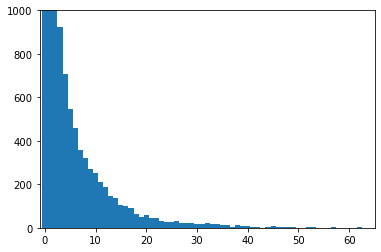

In [26]:
plt.hist(df_['annot_len'], bins=np.arange(65)-0.5)
plt.xlim((-1, 65))
plt.ylim(0, 1000)

In [28]:
X = []

for i in range(len(df_)):
    x =  np.array(tokenizer.encode(' '.join(df_['annot'].iloc[i]), truncation=True, padding='max_length', add_special_tokens=True, max_length=64))
    assert(len(x) == 64)
    X.append(x)

X = np.array(X)
# Y = tfk.utils.to_categorical(df_['category'], num_classes=42)

In [29]:
X.shape, Y.shape

AttributeError: 'list' object has no attribute 'shape'

## Model

In [8]:
input_ids_in   = tfk.layers.Input(shape=(64,), name='input_token', dtype='int32')
bert_model.trainable=False

embedding_layer = bert_model(input_ids_in)[0]
embedding_slice = embedding_layer[:,0,:]
x = tfk.layers.Dense(42, activation='softmax')(embedding_slice)
model = tf.keras.Model(inputs=input_ids_in, outputs=x)
model_embedding = tf.keras.Model(inputs=input_ids_in, outputs=embedding_slice)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_token (InputLayer)     [(None, 64)]              0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 64, 768),)        134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 42)                32298     
Total params: 134,766,378
Trainable params: 32,298
Non-trainable params: 134,734,080
_________________________________________________________________


In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.compile(optimizer=tfk.optimizers.Adam(learning_rate=1e-3),
              loss=tfk.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [27]:
model.fit(X, Y,
          epochs=15,
          batch_size=128,
          steps_per_epoch=200,
          validation_steps=20,
          validation_split=0.1,
          callbacks=[reduce_lr,
                     early_stop, 
                     #checkpoint, 
                     #tensorboard_callback,
                     #lr_tensorboard_callback,
                     #tqdm_callback
                    ]
          )

Epoch 1/15
200/200 [==============================] - 56s 278ms/step - loss: 3.5060 - accuracy: 0.0886 - val_loss: 5.6380 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/15
200/200 [==============================] - 54s 272ms/step - loss: 3.4728 - accuracy: 0.1052 - val_loss: 5.6512 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/15
200/200 [==============================] - 55s 273ms/step - loss: 3.4447 - accuracy: 0.1122 - val_loss: 5.6545 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/15
200/200 [==============================] - 55s 274ms/step - loss: 3.4356 - accuracy: 0.1173 - val_loss: 5.6543 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/15
200/200 [==============================] - 55s 274ms/step - loss: 3.4188 - accuracy: 0.1220 - val_loss: 5.6691 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/15
200/200 [==============================] - 55s 274ms/step - loss: 3.4081 - accuracy: 0.1268 - val_loss: 5.6518 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 7/15
200/200 [========

In [30]:
emb = model_embedding.predict(X, verbose=1)

381/381 [==============================] - 26s 69ms/step


In [31]:
emb.shape

(12186, 768)

In [32]:
df_emb = pd.DataFrame(emb)

In [33]:
df_res = df_[['filename', 'annot_len']].merge(df_emb, on=df_.index).drop('key_0', axis=1)
df_res.head()

,filename,annot_len,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,4,0.301740,0.035642,0.645422,0.184393,0.300565,-0.110420,-0.429352,-0.088092,...,-0.096835,0.455804,-0.353963,-0.642146,-0.174284,-0.118974,0.011540,0.537465,0.274709,-0.274494
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,0,0.226755,-0.063037,0.575984,0.141175,0.276204,-0.093213,-0.494611,0.059598,...,0.001799,0.421785,-0.216663,-0.693786,-0.090551,-0.078733,0.101649,0.539371,0.334486,-0.248356
2,127f3e6d6e3491b2459812353f33a913.jpg,5,0.230122,0.014947,0.629470,0.201817,0.197289,-0.100137,-0.524586,-0.013994,...,-0.043481,0.401430,-0.290804,-0.698697,-0.118225,-0.046748,0.030550,0.569611,0.310742,-0.270135
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,2,0.243957,0.050931,0.617198,0.097470,0.213967,-0.092841,-0.494858,0.011114,...,-0.109203,0.449101,-0.221006,-0.673565,-0.062738,-0.074305,0.041812,0.539332,0.329217,-0.252538
4,46d681a542f2c71be017eef6aae23313.jpg,1,0.234347,-0.052357,0.601979,0.129921,0.276907,-0.088497,-0.478140,0.046975,...,-0.008686,0.435282,-0.194707,-0.727289,-0.096276,-0.076775,0.094808,0.559078,0.342450,-0.254133


In [34]:
df_res.to_csv("shopee-product-detection-dataset/test_with_emb.csv")